# Predicting User Retention in a Healthcare SaaS  

**Objective:**  

Simulate and analyze behavioral data from a fictional healthcare SaaS product (calling it HealthHub), and identify which early user actions best predict 30-day retention.

 HealthHub helps users manage chronic conditions by offering tools to log metrics, track progress, access education, and schedule virtual consultations. This notebook simulates event-level data, defines product KPIs (D7 and D30 retention), and uses early behavior to build a simple predictive model for user retention.


## Notebook Structure

1. Simulate user and event data
2. Define product KPIs: D7 and D30 retention
3. Explore behavior patterns
4. Build retention prediction model (LogReg or RandomForest)
5. Interpret feature importance


In [3]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

## Step 1: Simulate User Table

We create a synthetic user base with:
- Unique `user_id`
- Randomized `signup_date` across 60 days
- Assigned `plan_type` (`free`, `premium`)
- Acquisition `channel` (`organic`, `ads`, `referral`, `doctor`)

In [4]:
n_users = 5000
start_date = datetime(2023, 1, 1)
signup_window_days = 60

plan_types = ['free', 'premium']
channels = ['organic', 'ads', 'referral', 'doctor']

np.random.seed(42)
random.seed(42)

users = pd.DataFrame({
    'user_id': range(1, n_users + 1),
    'signup_date': [start_date + timedelta(days=random.randint(0, signup_window_days)) for _ in range(n_users)],
    'plan_type': np.random.choice(plan_types, size=n_users, p=[0.7, 0.3]),
    'channel': np.random.choice(channels, size=n_users)
})

users['signup_date'] = pd.to_datetime(users['signup_date'])
users.head()


,user_id,signup_date,plan_type,channel
0,1,2023-02-10,free,referral
1,2,2023-01-08,premium,doctor
2,3,2023-01-02,premium,referral
3,4,2023-02-17,free,doctor
4,5,2023-01-18,free,doctor


##  Step 2: Simulate User Events (Behavioral Log)

We simulate a series of in-app actions performed by users across 45 days post-signup.

**Event Types:**
- `log_metric`
- `view_dashboard`
- `set_goal`
- `read_article`
- `schedule_consult`

In [5]:
event_types = ['log_metric', 'view_dashboard', 'set_goal', 'read_article', 'schedule_consult']
event_weights_free = [0.4, 0.3, 0.1, 0.15, 0.05]
event_weights_premium = [0.25, 0.25, 0.2, 0.15, 0.15]

event_data = []

for idx, row in users.iterrows():
    signup = row['signup_date']
    is_premium = row['plan_type'] == 'premium'

    # Premium users: more events on average
    n_events = np.random.poisson(7 if is_premium else 4) + 1

    weights = event_weights_premium if is_premium else event_weights_free

    for _ in range(n_events):
        offset_days = random.randint(0, 45)
        timestamp = signup + timedelta(
            days=offset_days,
            hours=random.randint(0, 23),
            minutes=random.randint(0, 59)
        )
        event_type = random.choices(event_types, weights=weights, k=1)[0]
        event_data.append([row['user_id'], timestamp, event_type])


In [6]:
events = pd.DataFrame(event_data, columns=['user_id', 'timestamp', 'event_type'])

## Step 3: Define Retention KPIs

We define two standard SaaS retention metrics:
- **D7 Retention**: user returns ≥7 days after signup
- **D30 Retention**: user returns ≥30 days after signup

In [7]:
from datetime import timedelta

def was_retained(user_id, days):
    signup_date = users.loc[users['user_id'] == user_id, 'signup_date'].values[0]
    # convert to datetime in case it's still object
    signup_date = pd.to_datetime(signup_date)
    cutoff_date = signup_date + timedelta(days=days)
    after_cutoff = events[
        (events['user_id'] == user_id) &
        (events['timestamp'] >= cutoff_date)
    ]
    return int(len(after_cutoff) >= 2)
# This ensures the user must have at least 2 real interactions after day 30 to be considered retained

In [8]:
users['retained_d7'] = users['user_id'].apply(lambda uid: was_retained(uid, 7))
users['retained_d30'] = users['user_id'].apply(lambda uid: was_retained(uid, 30))

In [9]:
# save data
import os
os.makedirs("data", exist_ok=True)

# Save user and event data
users.to_csv("/Users/lal/Desktop/Github/user-retention-analysis/data/users.csv", index=False)
events.to_csv("/Users/lal/Desktop/Github/user-retention-analysis/data/events.csv", index=False)

## Step 4: Add Signup Date to Events

To analyze behavior in the first 7 days, we merge each user's `signup_date` into the `events` table. This allows us to calculate how many days after signup each event occurred.

In [10]:
# Merge signup date into events table
events = events.merge(users[['user_id', 'signup_date']], on='user_id')

## Step 5: Calculate Days Since Signup

We compute a new column `days_since_signup`, which tells us how many days after signing up each event happened. We'll use this to isolate only the first week of activity.

In [11]:
events['days_since_signup'] = (events['timestamp'] - events['signup_date']).dt.days

## Step 6: Filter for First-Week Events

We focus only on user actions that occurred within the first 7 days after signup. These behaviors are the basis for predicting long-term retention.

In [12]:
events_week1 = events[events['days_since_signup'] <= 7]

## Step 7: Generate First-Week Behavioral Features

For each user, we calculate:
- Total number of events in week 1
- Number of times each event type was triggered
- Number of unique days the user was active

These features will help us understand early engagement patterns and train a predictive model.


In [13]:
# Total events per user
total_events = events_week1.groupby('user_id').size().rename('events_first_7_days')

# Event type counts per user
event_counts = events_week1.groupby(['user_id', 'event_type']).size().unstack(fill_value=0)

# Unique active days per user
active_days = events_week1.groupby('user_id')['timestamp'].apply(lambda x: x.dt.date.nunique()).rename('active_days_first_7')

# Combine all features
features_df = pd.concat([total_events, event_counts, active_days], axis=1).reset_index()

## Step 8: Combine with Retention Labels

We merge these week-1 behavior features with user-level information:
- `retained_d30` (our prediction target)
- `plan_type` and `channel` (can be used for segmentation)

This gives us a clean dataset ready for modeling.


In [14]:
features_df = features_df.merge(users[['user_id', 'retained_d30', 'plan_type', 'channel']], on='user_id')
features_df.head()

,user_id,events_first_7_days,log_metric,read_article,schedule_consult,set_goal,view_dashboard,active_days_first_7,retained_d30,plan_type,channel
0,1,1,0,0,1,0,0,1,0,free,referral
1,2,1,0,0,0,0,1,1,1,premium,doctor
2,3,2,1,0,1,0,0,2,1,premium,referral
3,4,1,0,0,0,0,1,1,1,free,doctor
4,5,2,0,0,0,1,1,2,0,free,doctor


## Step 9: Visualizing Retention Rates

Before modeling, we explore how retention varies across users based on early behaviors, acquisition channels, and subscription plans.

In [15]:
# Retention rate
retention_rate = features_df['retained_d30'].mean()
print(f"D30 Retention Rate: {retention_rate:.2%}")

D30 Retention Rate: 61.19%


### Retention by Plan Type

We check if premium users are more likely to stay engaged than free users.


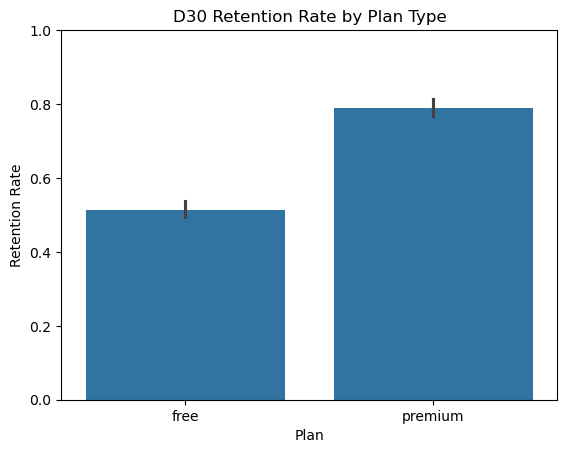

In [16]:
sns.barplot(
    data=features_df,
    x='plan_type',
    y='retained_d30',
    estimator=np.mean
)
plt.title('D30 Retention Rate by Plan Type')
plt.ylabel('Retention Rate')
plt.xlabel('Plan')
plt.ylim(0, 1)
plt.show()

In [17]:
plt.savefig("/Users/lal/Desktop/Github/user-retention-analysis/visualisations/retention_by_plan.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

## Event Usage by Retained vs. Churned Users

This chart shows how frequently users performed each action in their first 7 days, segmented by retention status at Day 30.

It helps identify high-signal behaviors: features that retained users tend to use more.


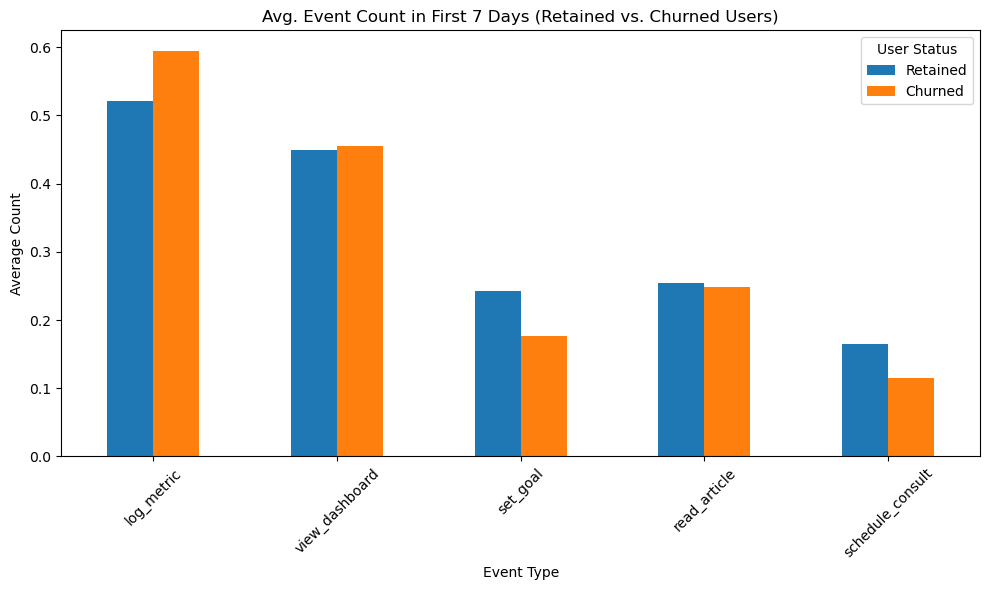

<Figure size 640x480 with 0 Axes>

In [18]:
event_columns = ['log_metric', 'view_dashboard', 'set_goal', 'read_article', 'schedule_consult']

retained_means = features_df[features_df['retained_d30'] == 1][event_columns].mean()
churned_means = features_df[features_df['retained_d30'] == 0][event_columns].mean()

event_df = pd.DataFrame({
    'Retained': retained_means,
    'Churned': churned_means
})

event_df.plot(kind='bar', figsize=(10, 6))
plt.title('Avg. Event Count in First 7 Days (Retained vs. Churned Users)')
plt.ylabel('Average Count')
plt.xlabel('Event Type')
plt.xticks(rotation=45)
plt.legend(title='User Status')
plt.tight_layout()
plt.show()

plt.savefig("/Users/lal/Desktop/Github/user-retention-analysis/visualisations/behavior_by_event_type.png", bbox_inches="tight")